Jonathan Sosa  

Jun - July 2023

Stock Predictor


In [181]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import concurrent.futures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# DATA COLLECTION
Fetch data from Yahoo Fiance from different stocks

In [113]:
apple_dta = yf.download('AAPL', start='2010-01-01', end='2023-05-01')
meta_dta = yf.download('META', start='2010-01-01', end='2023-05-01')
nike_dta = yf.download('NKE', start='2010-01-01', end='2023-05-01')
smp500_dta = yf.download('^GSPC', start='2010-01-01', end='2023-05-01')
vanguard_dta = yf.download('VOO', start='2010-01-01', end='2023-05-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [114]:
print(apple_dta.head())
print(meta_dta.head())
print(nike_dta.head())
print(smp500_dta.head())
print(vanguard_dta.head())

dta = [apple_dta, meta_dta, nike_dta, smp500_dta, vanguard_dta]

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.496294  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.507525  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.404014  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.392176  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.434674  447610800
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2012-05-18  42.049999  45.000000  38.000000  38.230000  38.230000  573576400
2012-05-21  36.529999  36.660000  33.000000  34.029999  34.029999  168192700
2012-05-22  32.610001  33.590000  30.940001  31.000000  31.000000  101786600
2012-05-23  31.370001  32.500000  31.360001  32.000000  32.000000   73600000
2012-05-24  32.950001  33.2

# DATA PROCESSING
handling missing values, converting data types, and creating new features

In [115]:
for d in dta:
    # Add a feature for the previous day's close price
    d['PrevClose'] = d['Close'].shift(1)

    # Add a feature for the change in close price from the previous day
    d['PriceChange'] = d['Close'] - d['PrevClose']

    # Shift the closing price by -1 to create a column for the next day's closing price
    d['NextClose'] = d['Close'].shift(-1)

    # Drop the last row of the dataframe, which will have a missing value for 'NextClose'
    d = d[:-1]

    d = d.dropna()
    
    print(d.head())

                Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.507525  601904800   
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.404014  552160000   
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.392176  477131200   
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.434674  447610800   
2010-01-11  7.600000  7.607143  7.444643  7.503929   6.377911  462229600   

            PrevClose  PriceChange  NextClose  
Date                                           
2010-01-05   7.643214     0.013215   7.534643  
2010-01-06   7.656429    -0.121786   7.520714  
2010-01-07   7.534643    -0.013929   7.570714  
2010-01-08   7.520714     0.050000   7.503929  
2010-01-11   7.570714    -0.066785   7.418571  
                 Open       High        Low      Close  Adj Close     Volume  \
Date                                               

In [116]:
# Check for missing values
for d in dta:
    print(d.isnull().sum())
   
    # This propagates the last valid observation forward to next valid.
    d.dropna()

Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
PrevClose      1
PriceChange    1
NextClose      1
dtype: int64
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
PrevClose      1
PriceChange    1
NextClose      1
dtype: int64
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
PrevClose      1
PriceChange    1
NextClose      1
dtype: int64
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
PrevClose      1
PriceChange    1
NextClose      1
dtype: int64
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
PrevClose      1
PriceChange    1
NextClose      1
dtype: int64


# DATA ANALYSIS(EDA)
understanding the data by summarizing its main characteristics, often through visual methods

### Apple Stock Analysis 

In [117]:
print(apple_dta.describe())

              Open         High          Low        Close    Adj Close  \
count  3353.000000  3353.000000  3353.000000  3353.000000  3353.000000   
mean     53.707076    54.311310    53.126484    53.744992    51.791305   
std      49.228549    49.864001    48.641289    49.284685    49.675132   
min       6.870357     7.000000     6.794643     6.858929     5.829696   
25%      19.194286    19.339287    19.000000    19.146070    16.756012   
50%      31.100000    31.237499    30.650000    31.062500    28.131504   
75%      66.394997    67.000000    65.750000    66.572502    65.130676   
max     182.630005   182.940002   179.119995   182.009995   180.434280   

             Volume    PrevClose  PriceChange    NextClose  
count  3.353000e+03  3352.000000  3352.000000  3352.000000  
mean   2.516429e+08    53.710405     0.048340    53.758746  
std    2.218363e+08    49.251322     1.431575    49.285602  
min    3.519590e+07     6.858929   -10.519997     6.858929  
25%    9.884470e+07    19.14

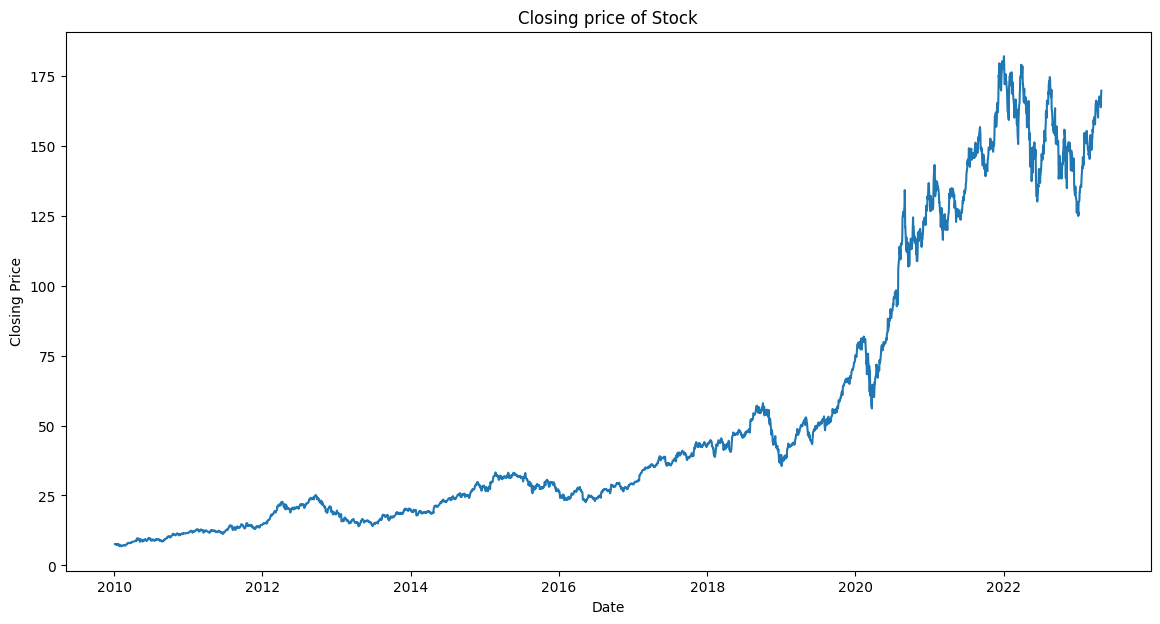

In [118]:
# Plot the closing price
plt.figure(figsize=(14, 7))
plt.plot(apple_dta['Close'])
plt.title('Closing price of Stock')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()


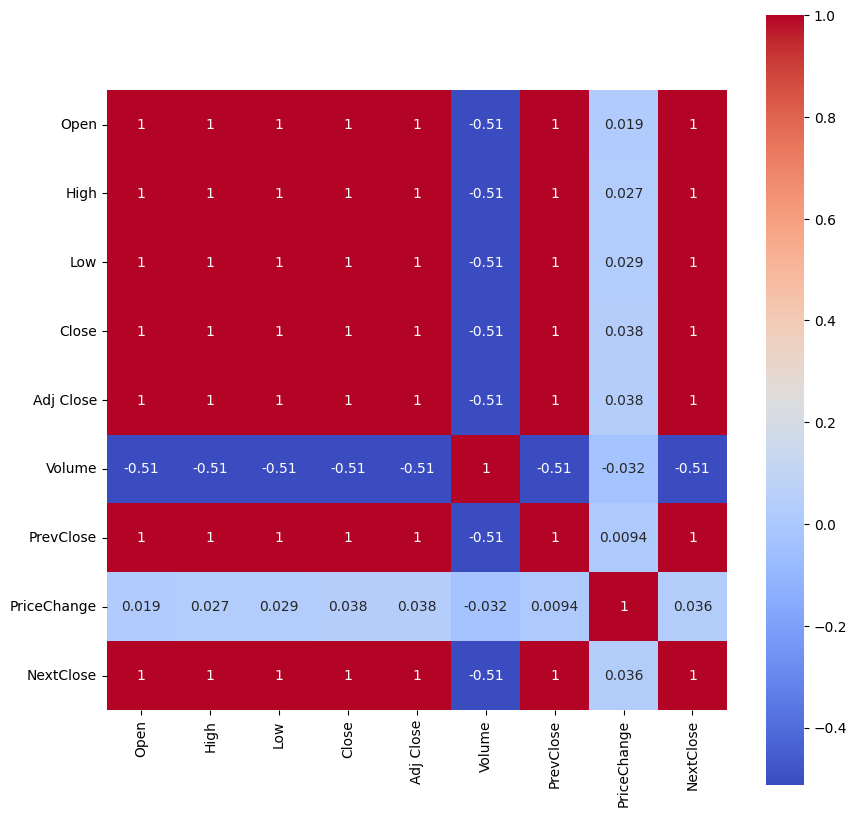

In [119]:
# Calculate correlations
corr = apple_dta.corr()

# Use seaborn to create a heatmap of the correlations
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, square=True, cmap='coolwarm')
plt.show()

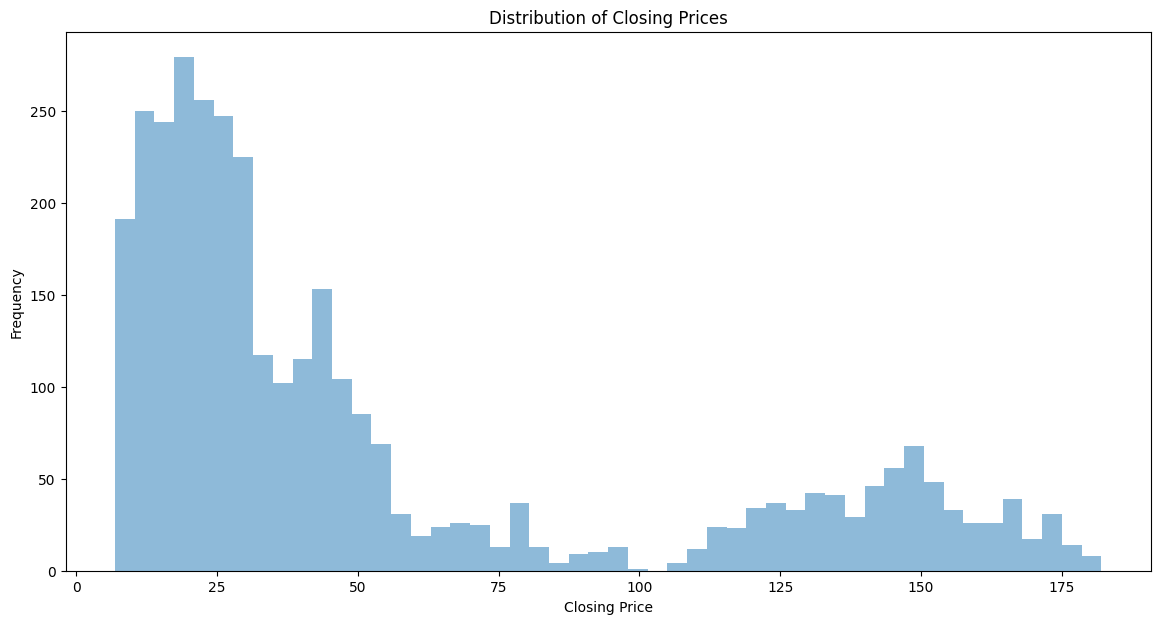

In [120]:
# Plot a histogram of the closing prices (Distribution of the data)
plt.figure(figsize=(14, 7))
plt.hist(apple_dta['Close'], bins=50, alpha=0.5)
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

### META Stock Analysis

In [121]:
print(meta_dta.describe())

              Open         High          Low        Close    Adj Close  \
count  2754.000000  2754.000000  2754.000000  2754.000000  2754.000000   
mean    148.917977   150.836235   147.038885   148.971685   148.971685   
std      86.016060    87.098821    84.975147    86.051165    86.051165   
min      18.080000    18.270000    17.549999    17.730000    17.730000   
25%      78.557503    79.404999    77.910004    78.710001    78.710001   
50%     145.915001   148.164993   143.364998   146.024994   146.024994   
75%     192.625000   195.315006   189.674999   192.455002   192.455002   
max     381.679993   384.329987   378.809998   382.179993   382.179993   

             Volume    PrevClose  PriceChange    NextClose  
count  2.754000e+03  2753.000000  2753.000000  2753.000000  
mean   3.117714e+07   148.938503     0.073407   149.011911  
std    2.697541e+07    86.049175     4.236531    86.040896  
min    5.913100e+06    17.730000   -85.240005    17.730000  
25%    1.636850e+07    78.69

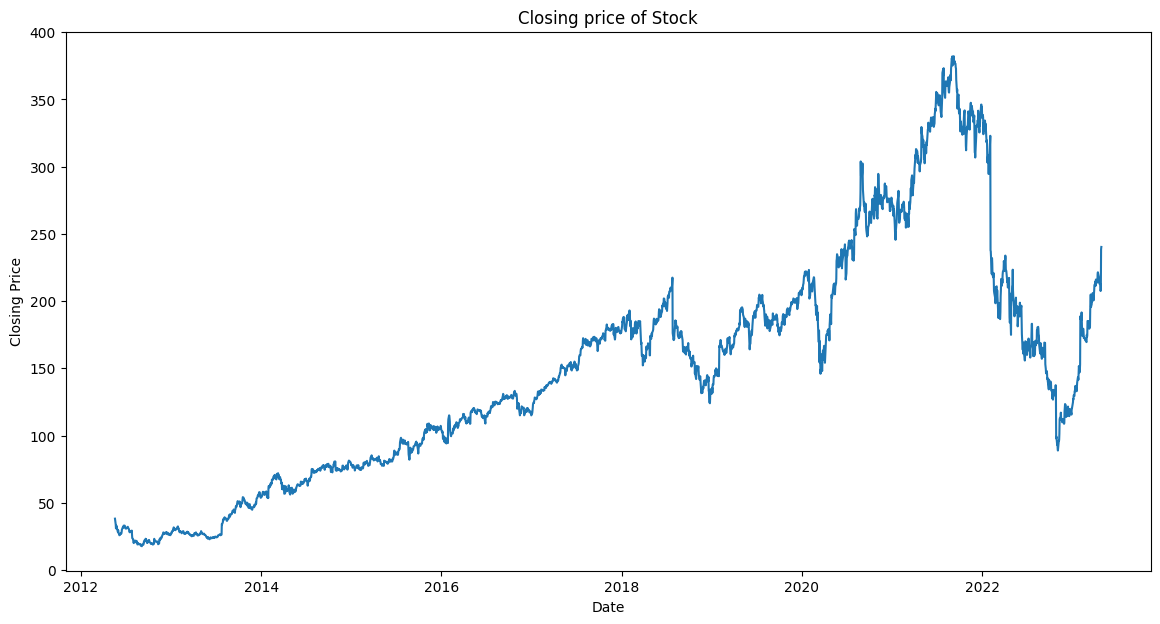

In [122]:
# Plot the closing price
plt.figure(figsize=(14, 7))
plt.plot(meta_dta['Close'])
plt.title('Closing price of Stock')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

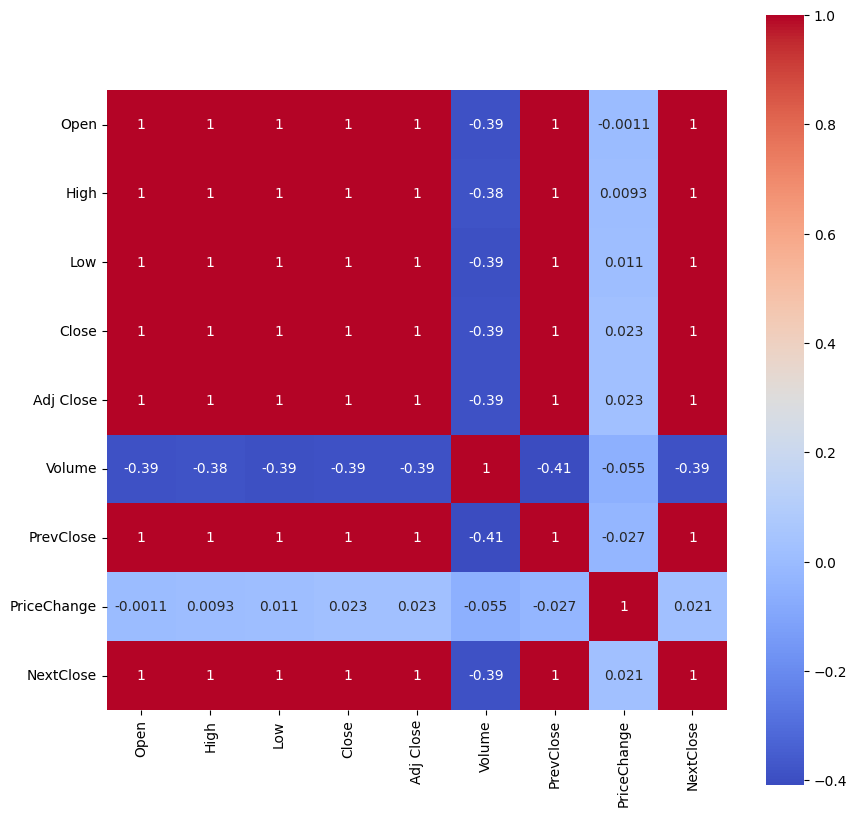

In [123]:
# Calculate correlations
corr = meta_dta.corr()

# Use seaborn to create a heatmap of the correlations
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, square=True, cmap='coolwarm')
plt.show()

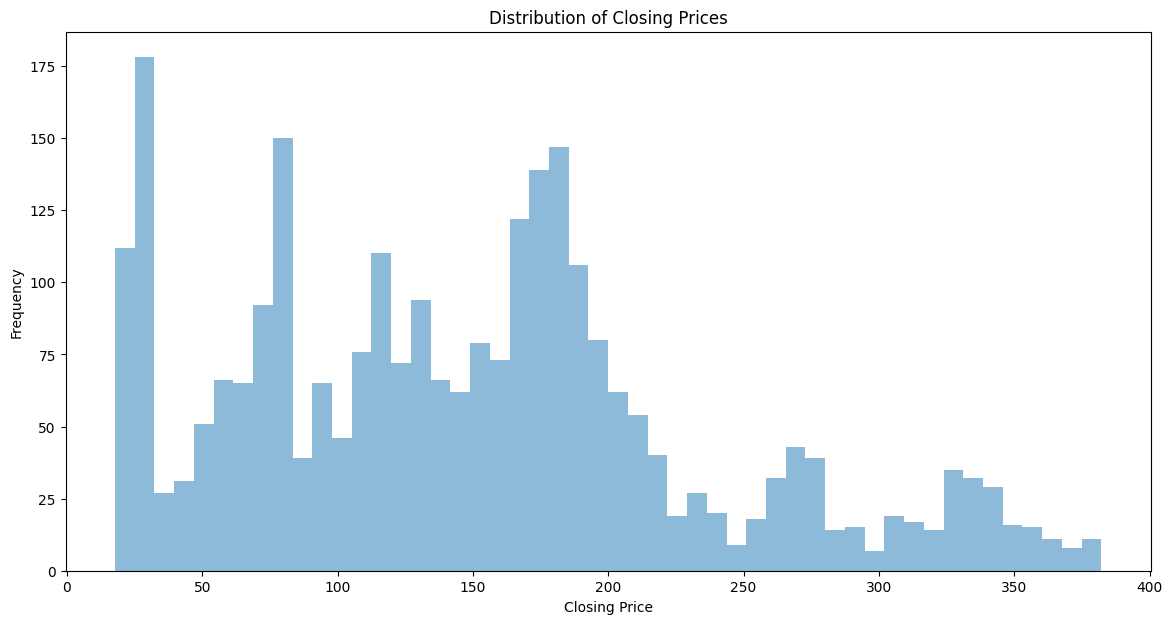

In [124]:
# Plot a histogram of the closing prices (data distribution)
plt.figure(figsize=(14, 7))
plt.hist(meta_dta['Close'], bins=50, alpha=0.5)
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

### Nike Stock Analysis

In [125]:
print(nike_dta.describe())

              Open         High          Low        Close    Adj Close  \
count  3353.000000  3353.000000  3353.000000  3353.000000  3353.000000   
mean     65.958087    66.617267    65.297244    65.964895    62.794045   
std      40.606411    41.035981    40.141070    40.579346    40.809685   
min      15.405000    15.530000    15.222500    15.325000    13.042219   
25%      30.809999    31.090000    30.605000    30.875000    27.633926   
50%      56.000000    56.459999    55.570000    56.040001    52.026329   
75%      89.970001    90.639999    88.720001    89.559998    87.168411   
max     176.350006   179.100006   175.500000   177.509995   174.236038   

             Volume    PrevClose  PriceChange    NextClose  
count  3.353000e+03  3352.000000  3352.000000  3352.000000  
mean   8.505546e+06    65.946770     0.032930    65.979700  
std    5.048087e+06    40.571823     1.443551    40.576342  
min    1.821900e+06    15.325000   -12.209999    15.325000  
25%    5.659400e+06    30.86

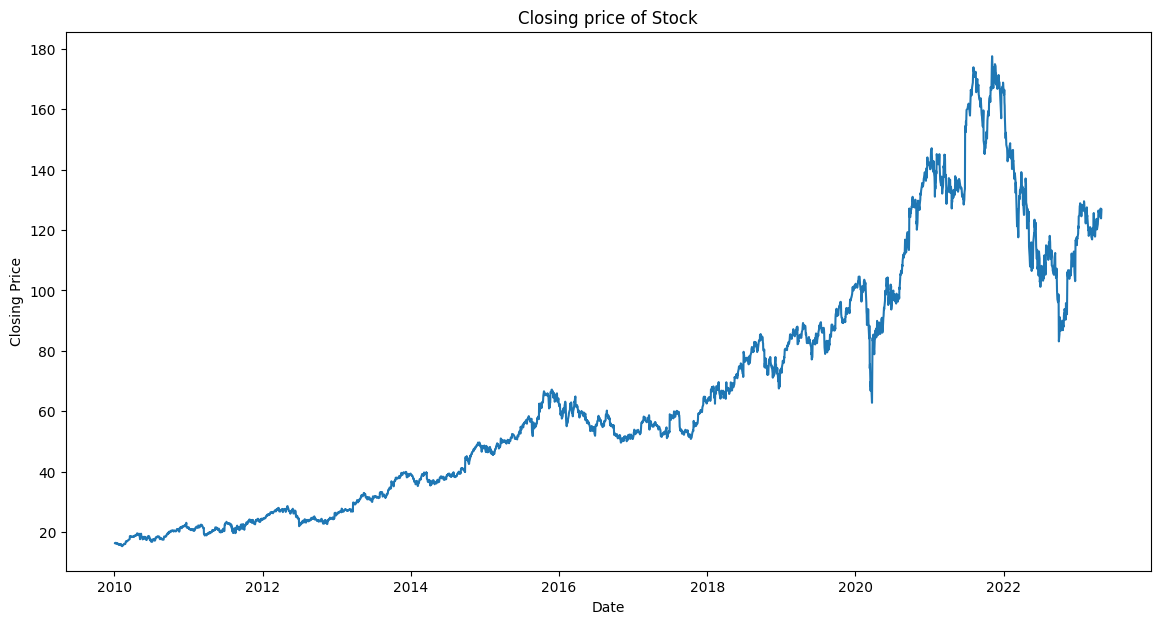

In [126]:
# Plot the closing price
plt.figure(figsize=(14, 7))
plt.plot(nike_dta['Close'])
plt.title('Closing price of Stock')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

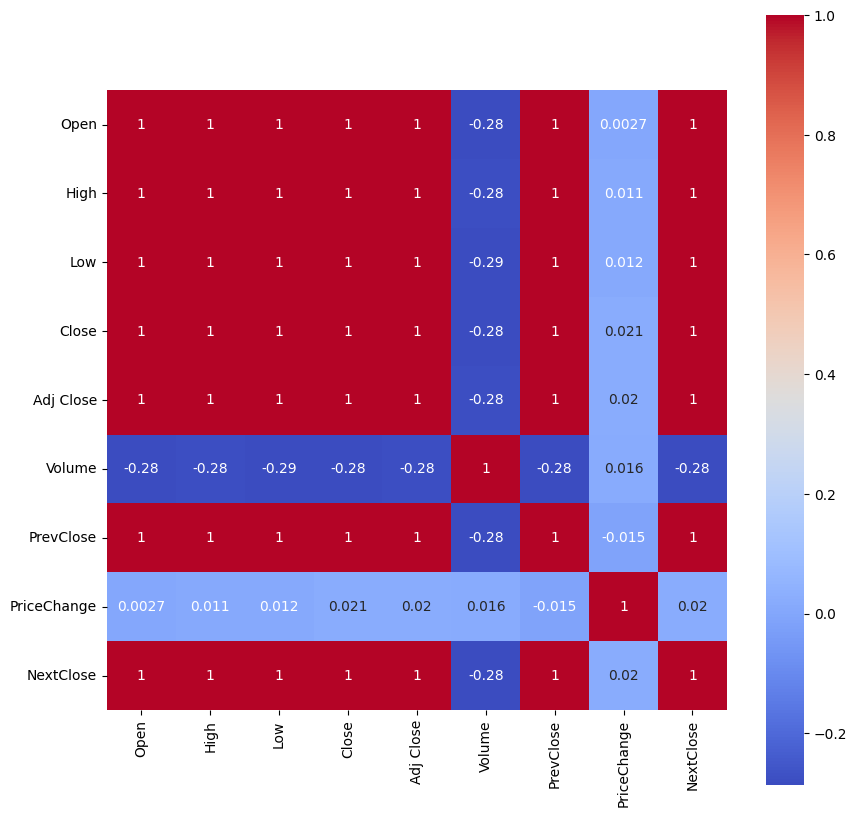

In [127]:
# Calculate correlations
corr = nike_dta.corr()

# Use seaborn to create a heatmap of the correlations
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, square=True, cmap='coolwarm')
plt.show()

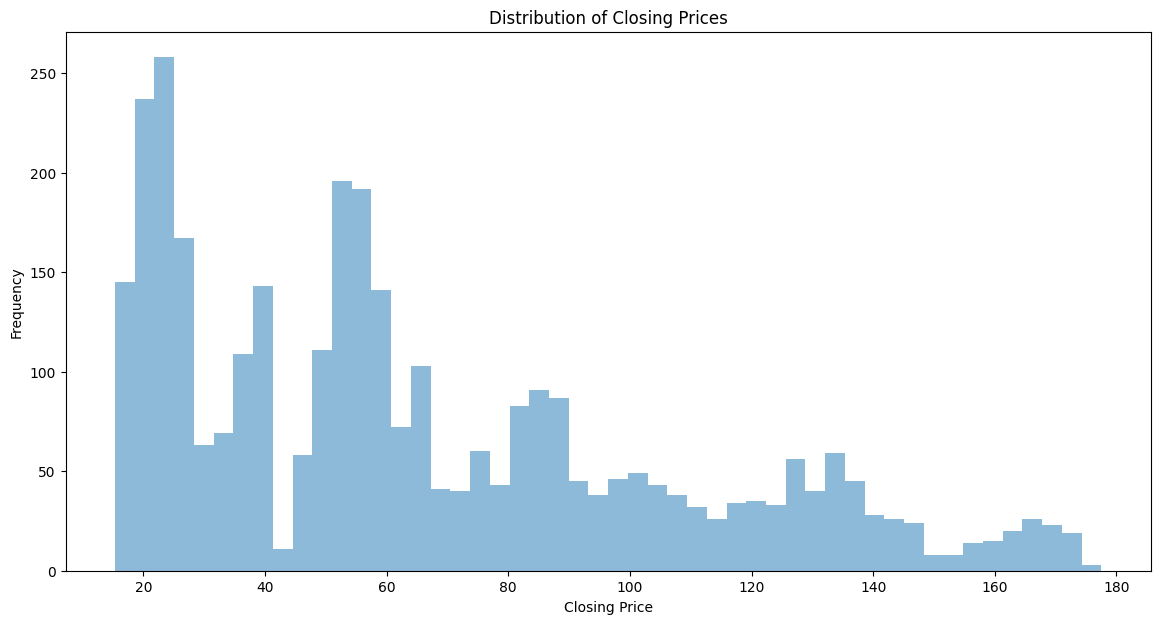

In [128]:
# Plot a histogram of the closing prices (Data distribution)
plt.figure(figsize=(14, 7))
plt.hist(nike_dta['Close'], bins=50, alpha=0.5)
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()


### SMP500 Stock Analysis

In [129]:
print(smp500_dta.describe())

              Open         High          Low        Close    Adj Close  \
count  3353.000000  3353.000000  3353.000000  3353.000000  3353.000000   
mean   2440.305218  2453.830686  2425.710981  2440.791431  2440.791431   
std    1008.452253  1014.883478  1001.523160  1008.466075  1008.466075   
min    1027.650024  1032.949951  1010.909973  1022.580017  1022.580017   
25%    1592.270020  1597.569946  1582.770020  1593.369995  1593.369995   
50%    2157.879883  2164.409912  2145.199951  2159.040039  2159.040039   
75%    3004.080078  3016.070068  2988.800049  3004.040039  3004.040039   
max    4804.509766  4818.620117  4780.040039  4796.560059  4796.560059   

             Volume    PrevClose  PriceChange    NextClose  
count  3.353000e+03  3352.000000  3352.000000  3352.000000  
mean   3.943333e+09  2440.275713     0.905874  2441.181587  
std    9.723338e+08  1008.174225    30.370633  1008.363410  
min    1.025000e+09  1022.580017  -324.890137  1022.580017  
25%    3.350670e+09  1593.13

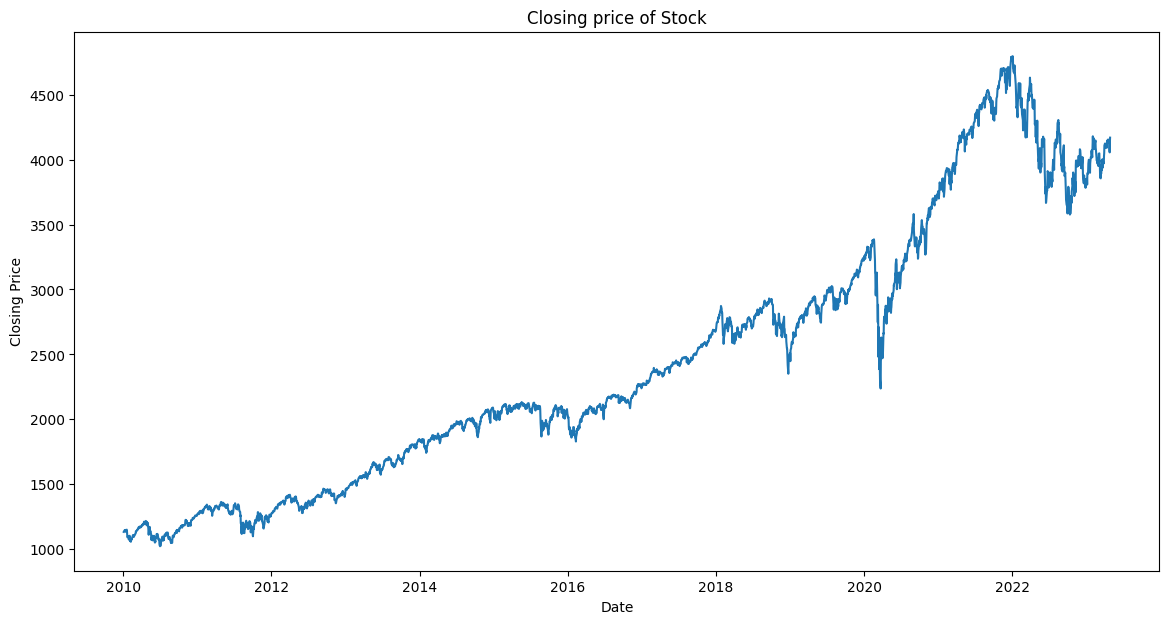

In [130]:
# Plot the closing price
plt.figure(figsize=(14, 7))
plt.plot(smp500_dta['Close'])
plt.title('Closing price of Stock')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

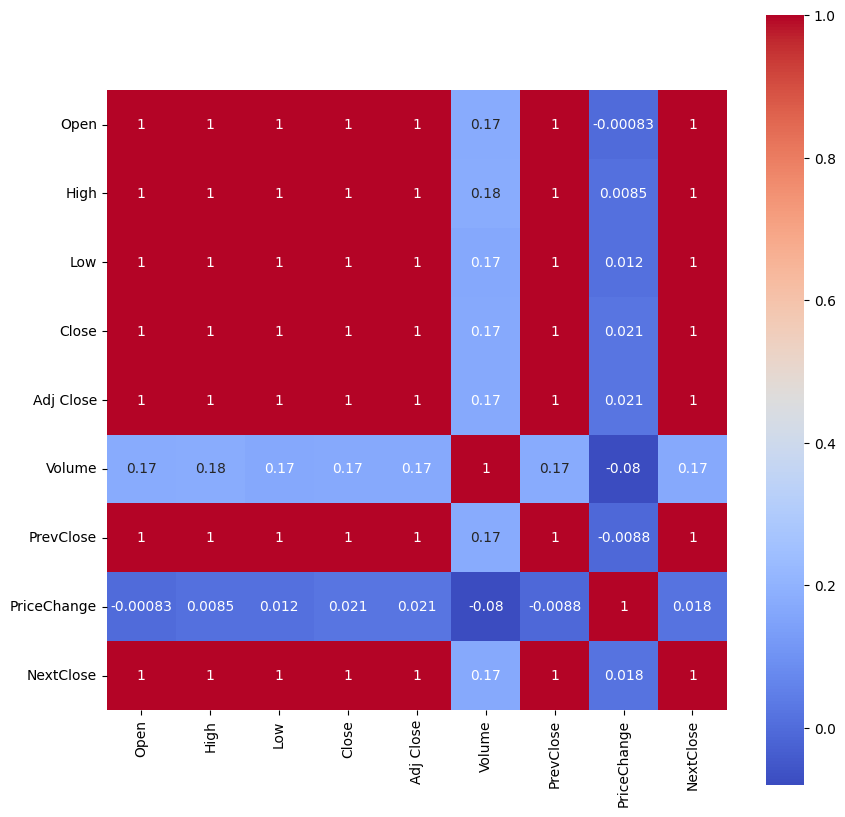

In [131]:
# Calculate correlations
corr = smp500_dta.corr()

# Use seaborn to create a heatmap of the correlations
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, square=True, cmap='coolwarm')
plt.show()

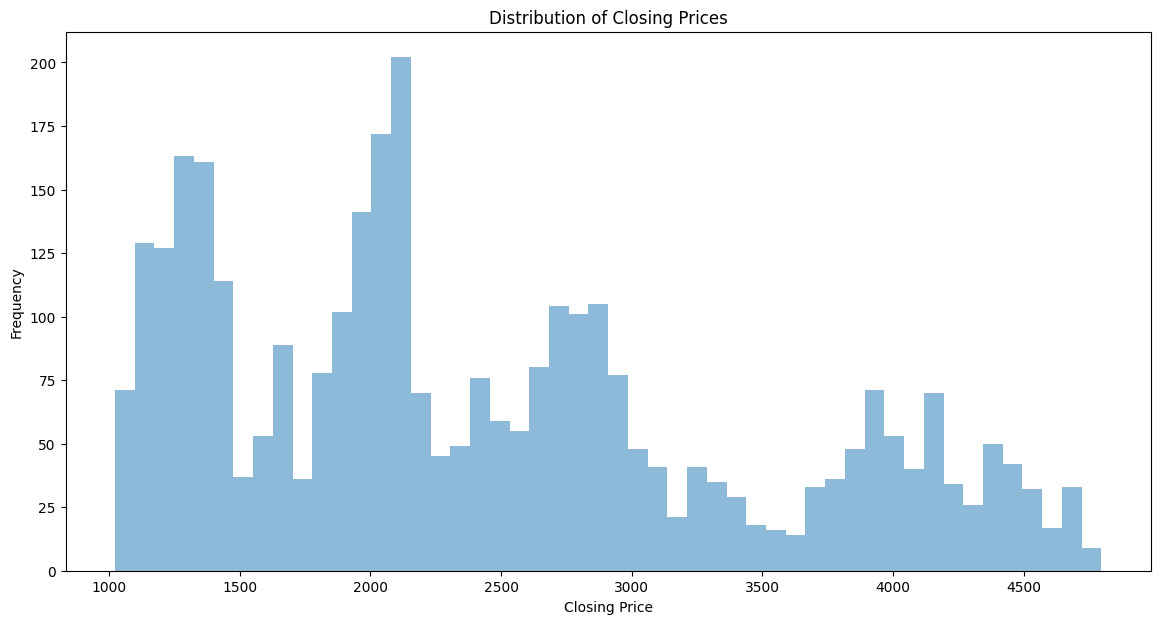

In [132]:
# Plot a histogram of the closing prices
plt.figure(figsize=(14, 7))
plt.hist(smp500_dta['Close'], bins=50, alpha=0.5)
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

### Vanguard 500 Stock Analysis

In [133]:
print(vanguard_dta.describe())

              Open         High          Low        Close    Adj Close  \
count  3181.000000  3181.000000  3181.000000  3181.000000  3181.000000   
mean    230.441827   231.658419   229.091116   230.470195   210.526896   
std      90.473207    91.091943    89.799194    90.484726    96.037200   
min      99.139999   101.860001    98.239998   100.339996    79.369987   
25%     161.330002   162.070007   160.800003   161.399994   135.348160   
50%     207.919998   208.429993   207.330002   207.919998   185.084579   
75%     283.640015   285.640015   282.579987   283.929993   268.224426   
max     440.579987   441.260010   437.660004   439.250000   428.554657   

             Volume    PrevClose  PriceChange    NextClose  
count  3.181000e+03  3180.000000  3180.000000  3180.000000  
mean   2.480157e+06   230.422528     0.088280   230.510808  
std    2.373732e+06    90.459004     2.831959    90.469954  
min    8.600000e+03   100.339996   -29.069992   100.339996  
25%    8.768500e+05   161.38

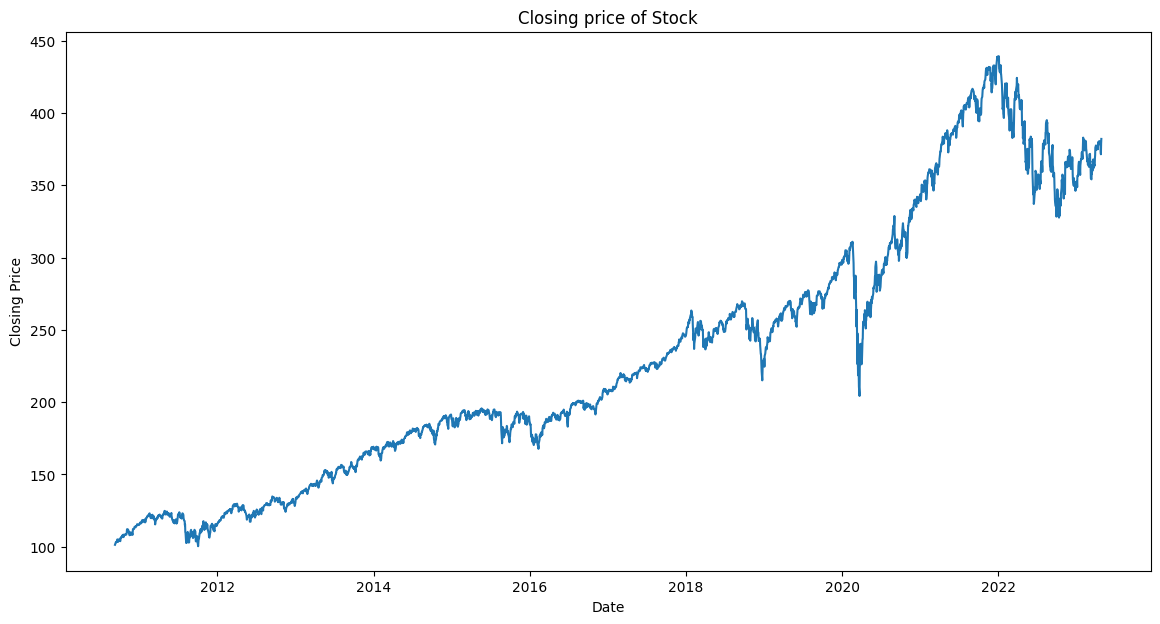

In [134]:
# Plot the closing price
plt.figure(figsize=(14, 7))
plt.plot(vanguard_dta['Close'])
plt.title('Closing price of Stock')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

                 Open      High       Low     Close  Adj Close    Volume  \
Open         1.000000  0.999884  0.999838  0.999718   0.999056  0.632076   
High         0.999884  1.000000  0.999755  0.999834   0.999334  0.636975   
Low          0.999838  0.999755  1.000000  0.999851   0.999015  0.624988   
Close        0.999718  0.999834  0.999851  1.000000   0.999327  0.630621   
Adj Close    0.999056  0.999334  0.999015  0.999327   1.000000  0.634546   
Volume       0.632076  0.636975  0.624988  0.630621   0.634546  1.000000   
PrevClose    0.999806  0.999733  0.999632  0.999510   0.998889  0.634976   
PriceChange  0.001056  0.007100  0.010863  0.019518   0.017857 -0.141661   
NextClose    0.999271  0.999389  0.999411  0.999510   0.998891  0.630812   

             PrevClose  PriceChange  NextClose  
Open          0.999806     0.001056   0.999271  
High          0.999733     0.007100   0.999389  
Low           0.999632     0.010863   0.999411  
Close         0.999510     0.019518   0.999

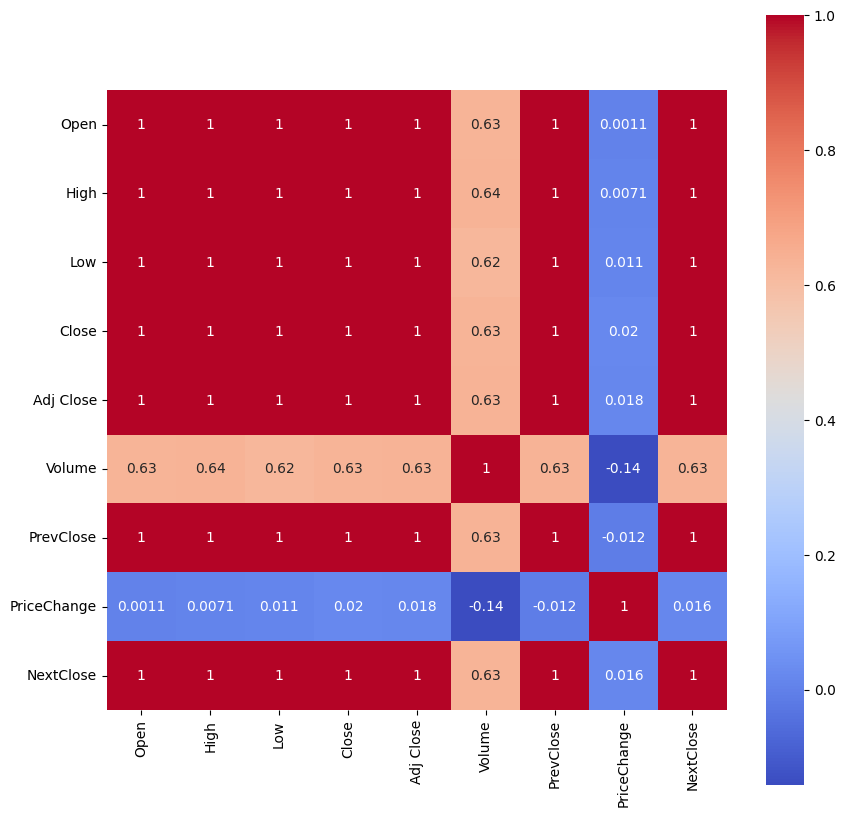

In [135]:
# Calculate correlations
corr = vanguard_dta.corr()
print(corr)

# Use seaborn to create a heatmap of the correlations
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, square=True, cmap='coolwarm')
plt.show()

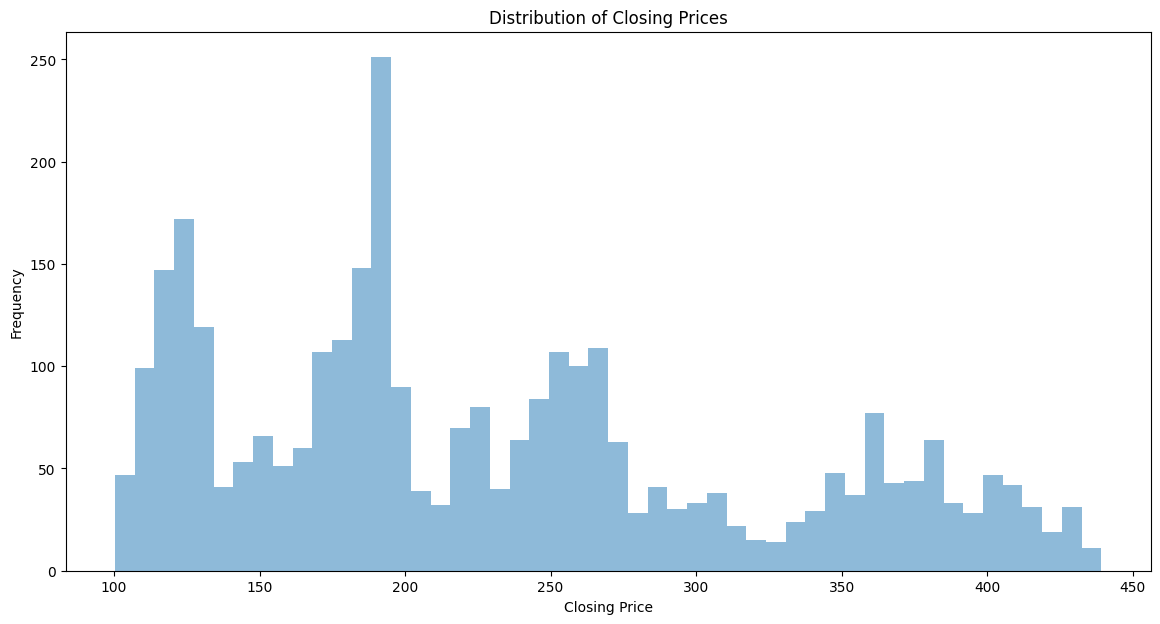

In [136]:
# Plot a histogram of the closing prices
plt.figure(figsize=(14, 7))
plt.hist(vanguard_dta['Close'], bins=50, alpha=0.5)
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()


# Model Selection

In [137]:
def split_data(data, target_col, test_size):
    '''
    This function takes the data and divides it into test and train datasets
    ----------------
    Inputs:
    data: pandas df
    target_col: string (name of the target column)
    test_size: float
    -----------------
    Outputs:
    X_train: pandas df
    X_test: pandas df
    y_train: pandas Series
    y_test: pandas Series
    '''
    
    # Separate features and target
    X = data.drop(columns=[target_col])
    y = data[target_col]

    # Calculate the index at which to split the data
    split_idx = int(len(data) * (1 - test_size))

    # Split the data
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    y_train = y[:split_idx]
    y_test = y[split_idx:]

    return (X_train, X_test, y_train, y_test)

In [148]:
def evaluate(predictions, y_test):
    '''
    This function evaluates the model
    ----------------
    Inputs:
    model: selected model
    X_test: pandas df
    y_test: pandas df
    -----------------
    Outputs:
    mae: float
    mse: float
    rmse: float
    '''
    
    # Calculate the MAE
    mae = mean_absolute_error(y_test, predictions)
    
    # Calculate the MSE
    mse = mean_squared_error(y_test, predictions)
    
    # Calculate the RMSE
    rmse = sqrt(mse)
    
    # Return the metrics
    return mae, mse, rmse

### Regression

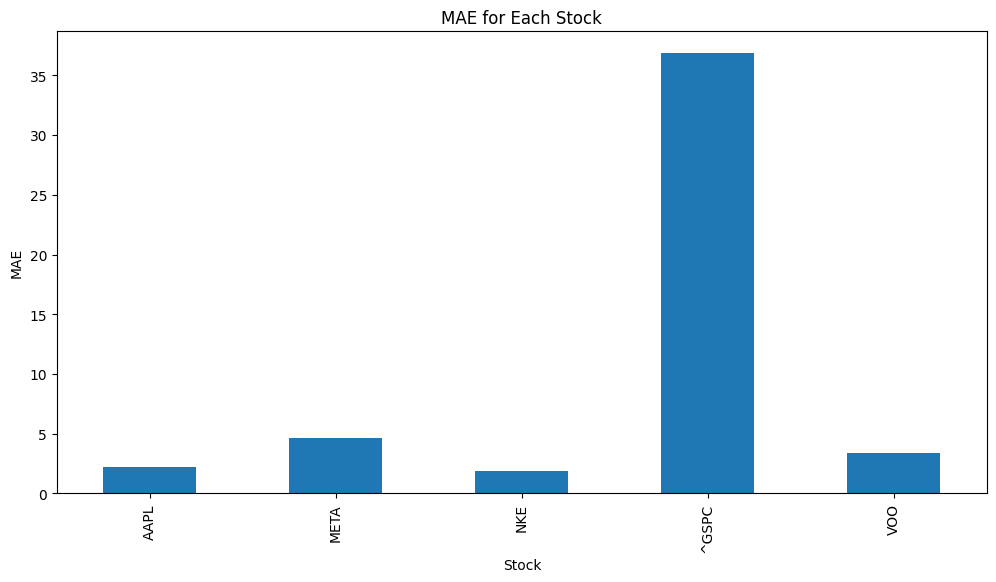

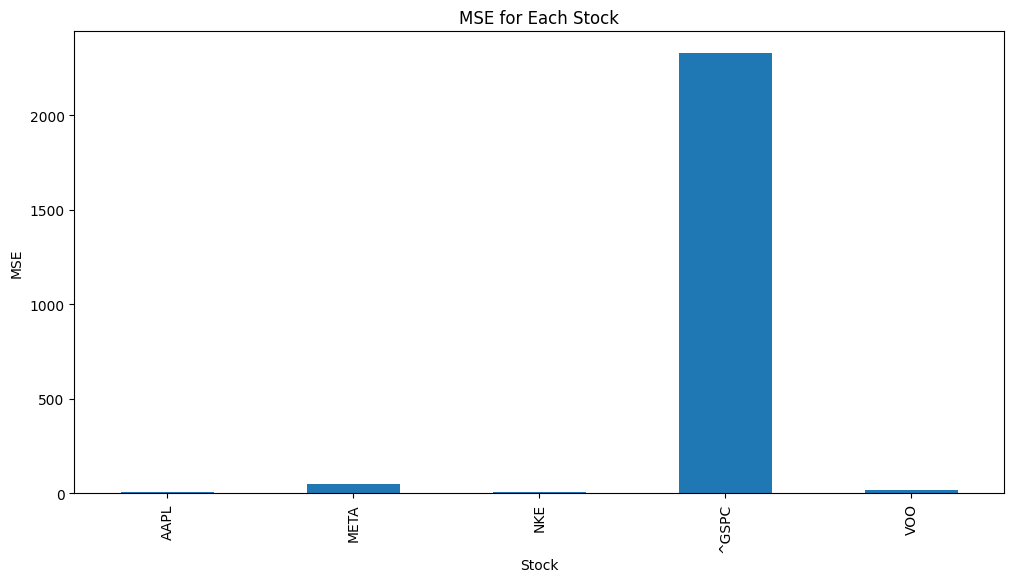

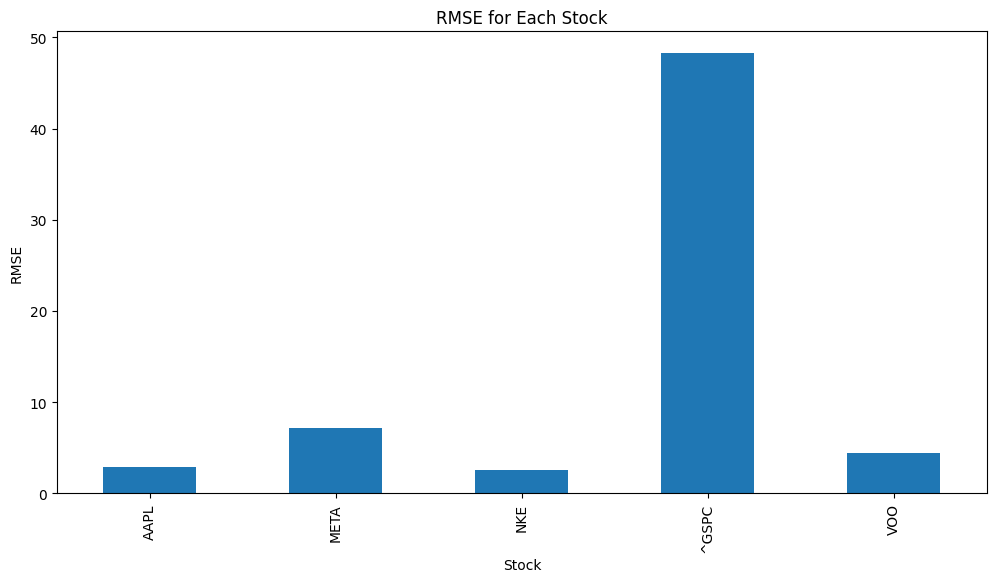

In [149]:
dta = [apple_dta, meta_dta, nike_dta, smp500_dta, vanguard_dta]

# Define a function to train a model on a single stock
def train_model(stock, data):

    data = data.dropna()
    # Preprocess the data (assuming preprocess is a function you've defined)
    X_train, X_test, y_train, y_test = split_data(data, 'NextClose', 0.2)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Use the model to make predictions
    predictions = model.predict(X_test)
    
    # Evaluate the model (assuming evaluate is a function you've defined)
    mae, mse, rmse = evaluate(predictions, y_test)
    
    return stock, mae, mse, rmse

# List of stocks to train models on
stocks = ['AAPL', 'META', 'NKE', '^GSPC', 'VOO']

# Create a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use the executor to map the train_model function to the stocks
    results = executor.map(train_model, stocks, dta)
    
# Convert the results to a list
results_list_regression = list(results)

# Create a DataFrame from the results
results_df_regression = pd.DataFrame(results_list_regression, columns=['Stock', 'MAE', 'MSE', 'RMSE'])

# Set the stock symbols as the index
results_df_regression.set_index('Stock', inplace=True)

# Create a bar plot for each metric
for metric in ['MAE', 'MSE', 'RMSE']:
    results_df_regression[metric].plot(kind='bar', figsize=(12, 6))
    plt.title(f'{metric} for Each Stock')
    plt.ylabel(metric)
    plt.show()


### ARIMA (AutoRegressive Integrated Moving Average)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarnin

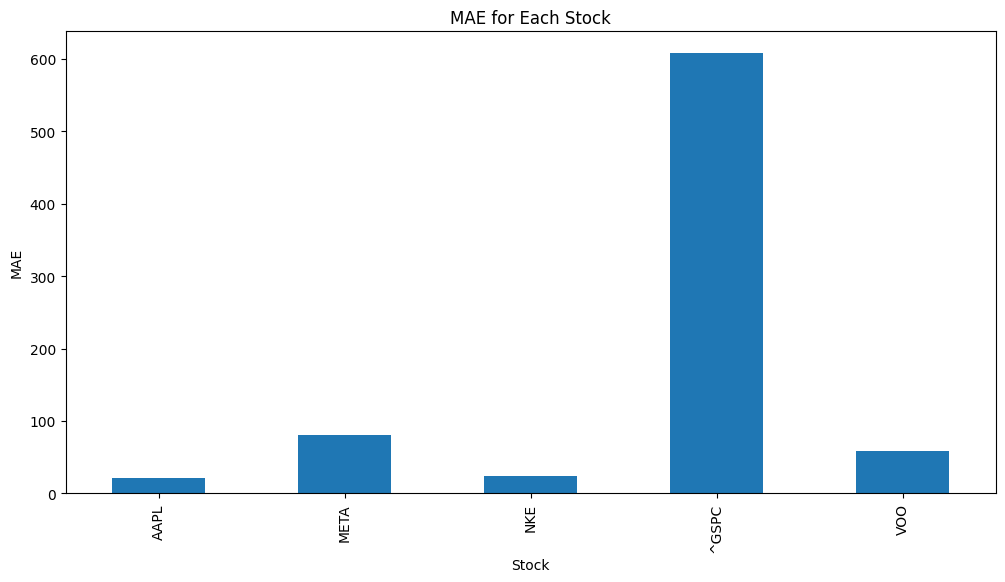

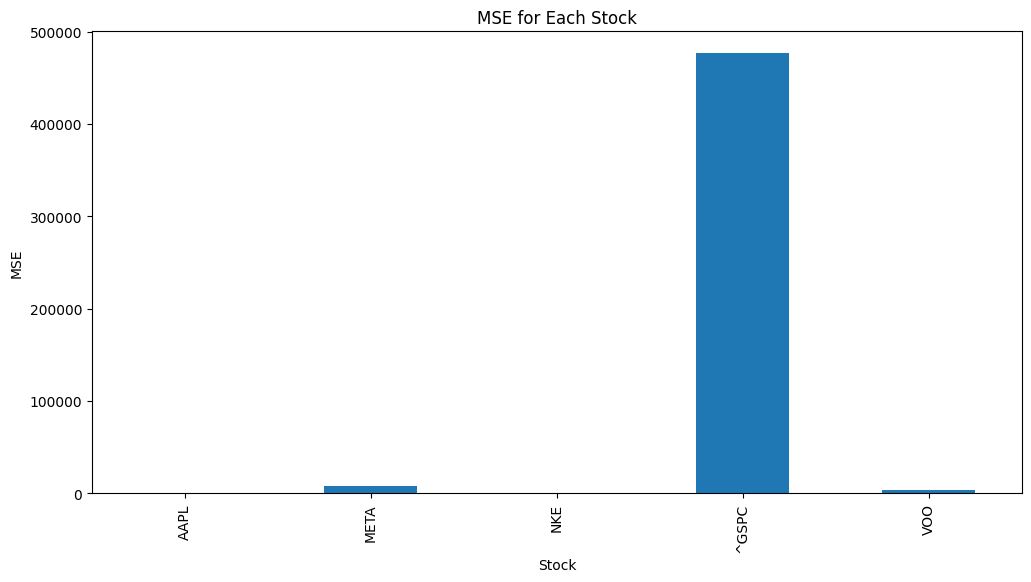

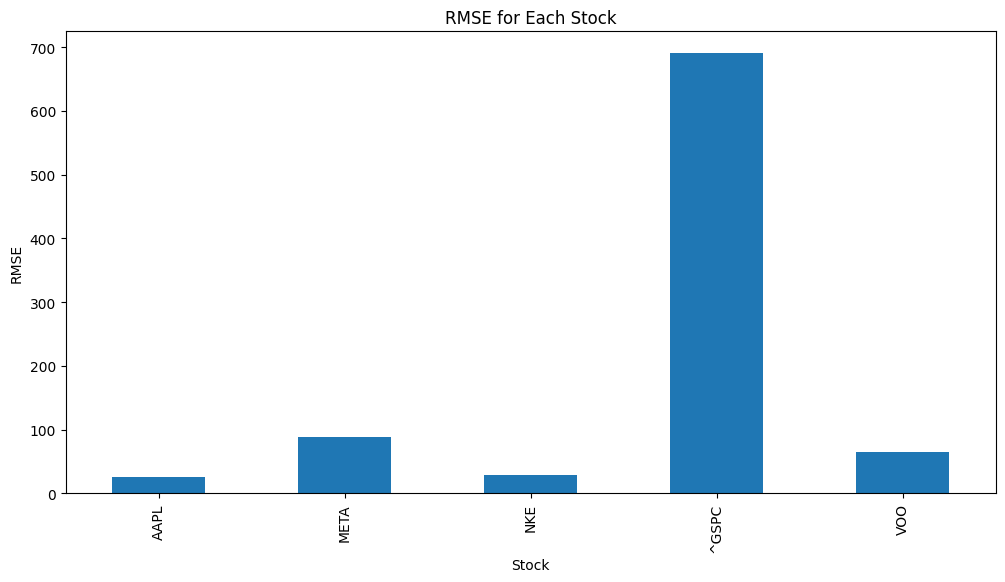

In [176]:
# Define a function to train a model on a single stock
def train_model_arima(stock, data):
    try:
        # Drop any rows with missing values
        data = data.dropna()

        # Split the data into a training set and a test set
        # We're predicting 'NextClose', so that's our y variable
        X_train, X_test, y_train, y_test = split_data(data, 'NextClose', 0.2)

        # Specify the order of the ARIMA model
        # This will depend on your specific data
        order = (1, 1, 1)
    
        # Train the model
        model = ARIMA(y_train, order=order)
        model_fit = model.fit()

        # Use the model to make predictions on the test set
        predictions = model_fit.forecast(steps=len(y_test))

        # Evaluate the model
        mae, mse, rmse = evaluate(predictions, y_test)
    
        return stock, mae, mse, rmse
    except Exception as e:
        return stock, str(e), None, None
    
def train_wrapper(args):
    return train_model_arima(*args)

with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use the executor to map the train_wrapper function to the arguments
    results = executor.map(train_wrapper, zip(stocks, dta))

# Convert the results to a list
results_list_ARIMA = list(results)

# Create a DataFrame from the results
results_df_ARIMA = pd.DataFrame(results_list_ARIMA, columns=['Stock', 'MAE', 'MSE', 'RMSE'])

# Set the stock symbols as the index
results_df_ARIMA.set_index('Stock', inplace=True)

# Create a bar plot for each metric
for metric in ['MAE', 'MSE', 'RMSE']:
    results_df_ARIMA[metric].plot(kind='bar', figsize=(12, 6))
    plt.title(f'{metric} for Each Stock')
    plt.ylabel(metric)
    plt.show()


### LSTM (Long Short-Term Memory)

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
84/84 [==============================] - 4s 6ms/step - loss: 976.7074
Epoch 2/50
84/84 [==============================] - 5s 6ms/step - loss: 4498782.0000
Epoch 2/50
80/80 [==============================] - 5s 5ms/step - loss: 38483.5273
Epoch 2/50
84/84 [==============================] - 5s 5ms/step - loss: 2368.6357
Epoch 2/50
69/69 [==============================] - 5s 5ms/step - loss: 19377.8555
Epoch 2/50
84/84 [==============================] - 0s 5ms/step - loss: 685.9602
Epoch 3/50
69/69 [==============================] - 0s 5ms/step - loss: 17625.2988
Epoch 3/50
80/80 [==============================] - 0s 5ms/step - loss: 35668.9297
Epoch 3/50
84/84 [==============================] - 0s 5ms/step - loss: 4467610.5000
Epoch 3/50
84/84 [==============================] - 0s 5ms/step - loss: 1779.2468
Epoch 3/50
69/69 [==============================] - 0s 5ms/step - loss: 16734.4160
Epoch 4/50
84/84 [===========================

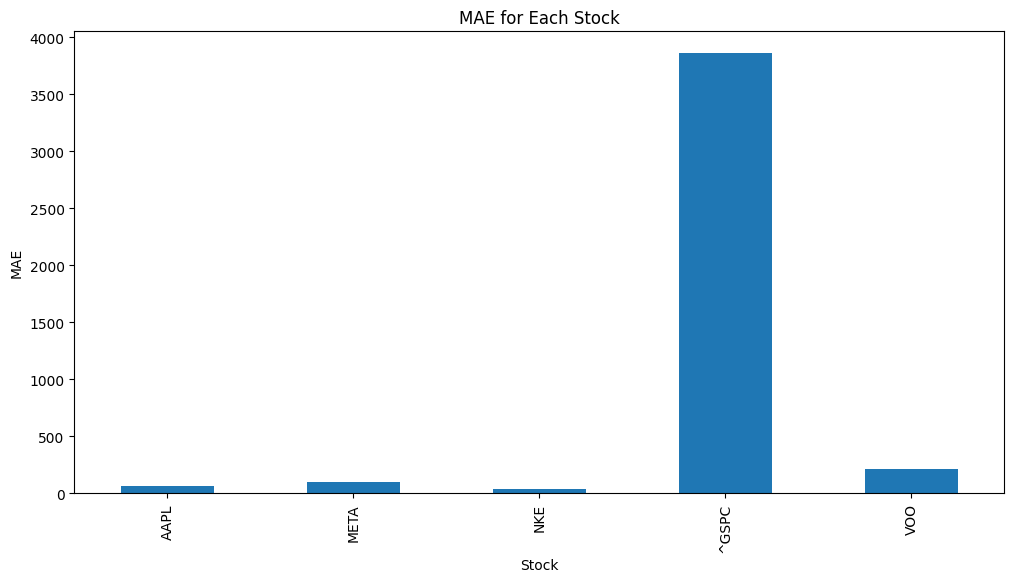

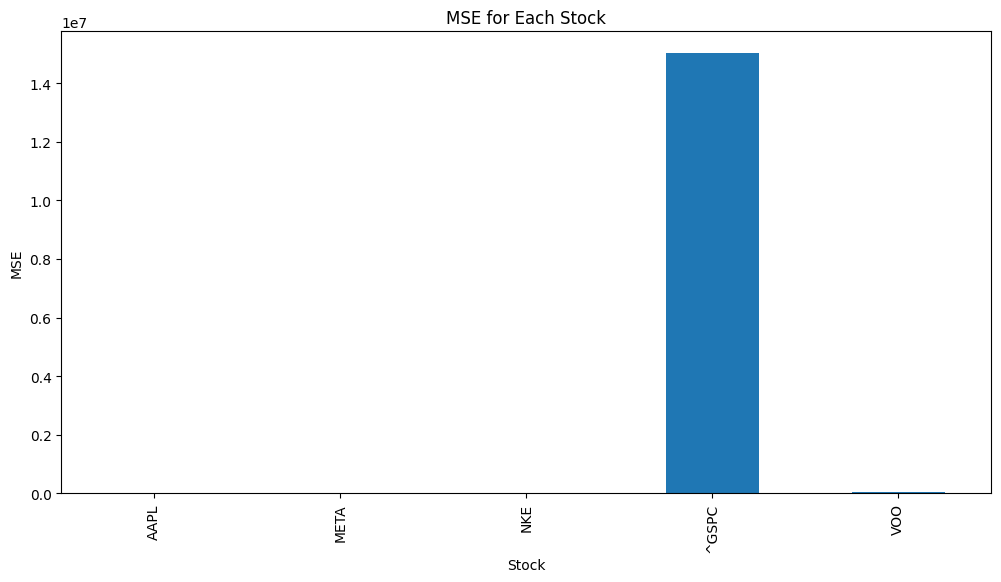

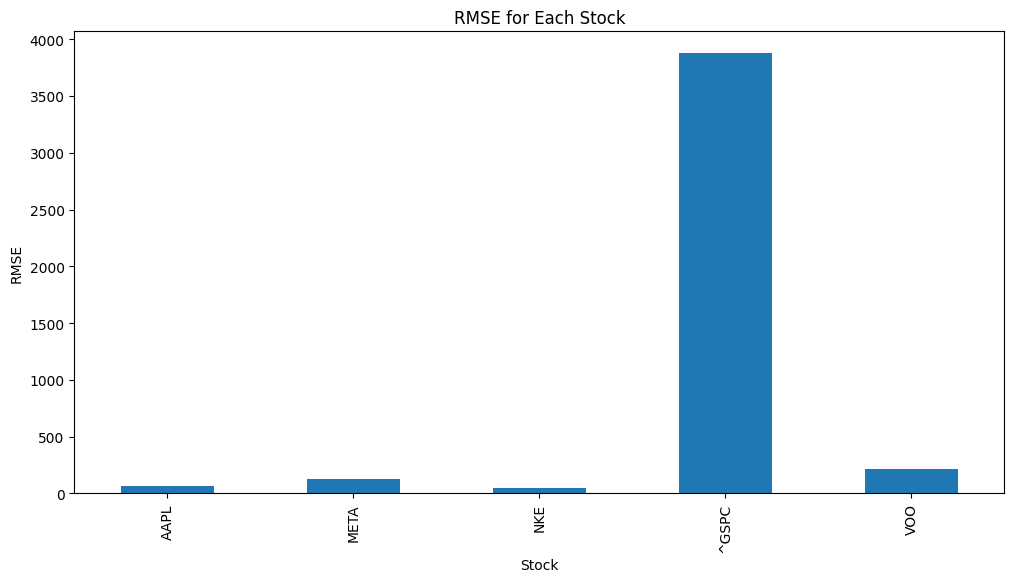

In [182]:
def train_model_lstm(stock, data):
    # Drop any rows with missing values
    data = data.dropna()

    # Preprocess the data
    X_train, X_test, y_train, y_test = split_data(data, 'NextClose', 0.2)

    # Convert DataFrame to Numpy array before reshaping
    X_train, X_test = X_train.values, X_test.values

    # Reshape the data to add a third dimension
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Reshape the data to add a third dimension
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32)

    # Use the model to make predictions
    predictions = model.predict(X_test)

    # Evaluate the model
    mae, mse, rmse = evaluate(predictions, y_test)
    
    return stock, mae, mse, rmse

def train_wrapper(args):
    return train_model_lstm(*args)

with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use the executor to map the train_wrapper function to the arguments
    results = executor.map(train_wrapper, zip(stocks, dta))

# Convert the results to a list
results_list_lstm = list(results)

# Create a DataFrame from the results
results_df_lstm = pd.DataFrame(results_list_lstm, columns=['Stock', 'MAE', 'MSE', 'RMSE'])

# Set the stock symbols as the index
results_df_lstm.set_index('Stock', inplace=True)

# Create a bar plot for each metric
for metric in ['MAE', 'MSE', 'RMSE']:
    results_df_lstm[metric].plot(kind='bar', figsize=(12, 6))
    plt.title(f'{metric} for Each Stock')
    plt.ylabel(metric)
    plt.show()


### Prophet